In [17]:
import sys
import os

# Dynamically add the root directory to sys.path
# Assumes that 'models' and 'utils' are in the same project root directory
project_root = os.path.abspath(os.path.join(os.path.dirname('.'), '..'))
sys.path.insert(0, project_root)


In [22]:
import math
from sklearn.metrics import accuracy_score
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torcheeg import transforms
from torch.utils.data import DataLoader
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from torcheeg.datasets import DREAMERDataset
from torcheeg.model_selection import KFoldGroupbyTrial
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Local Imports
from utils.checkpoint import train_and_save
from utils.log import get_logger
from utils.utils import print_var, train_one_epoch, train_one_epoch_lstm, get_num_params, train_one_step_tqdm
from models.cnn import Two_Layer_CNN, Two_Layer_CNN_Pro, Simplified_CNN
from models.rnns import LSTM

In [ ]:
dataset_name = 'Dreamer_time_series_01'
emotion_dim = 'valence'  # valence, dominance, or arousal

mat_path = '../raw_data/DREAMER.mat'  # path to the DREAMER.mat file
io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset

# Import data
dataset = DREAMERDataset(io_path=f"{io_path}",
                        mat_path=mat_path,
                        offline_transform=transforms.Compose([
                            transforms.MeanStdNormalize(),#MeanStdNormalize() , MinMaxNormalize()
                        ]),
                        online_transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]),
                        label_transform=transforms.Compose([
                            transforms.Select(emotion_dim),
                            transforms.Binary(threshold=2.5),
                             
                        ]),
                        chunk_size=128,
                        baseline_chunk_size=128,
                        num_baseline=61,
                        num_worker=4)



[2024-11-24 17:14:33] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to ../saves/datasets/Dreamer_time_series_02.
[2024-11-24 17:14:33] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]:  17%|█▋        | 4/23 [00:00<00:00, 29.41it/s]
[RECORD 0]: 0it [00:00, ?it/s]

ValueError: cannot reshape array of size 109312 into shape (14,61,256)

[PROCESS]:  17%|█▋        | 4/23 [00:13<00:00, 29.41it/s]

In [68]:
109312/256
109312/256/61

7.0

In [58]:
dataset[0][0].shape

torch.Size([14, 128])

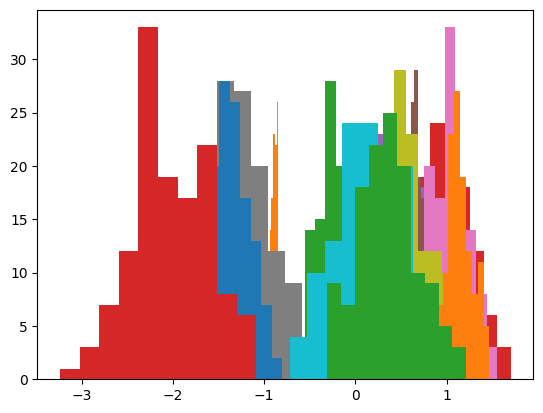

In [53]:
for i in range(14):
    plt.hist(dataset[18][0][i,:])
